In [1]:
# notebooks/03_LSTMPipeline.ipynb
# End-to-end deep learning pipeline for ERA5 precipitation prediction using LSTM model

# LOAD LIBRARIES

In [2]:
import sys
from pathlib import Path
sys.path.append(str(Path("../").resolve()))

from src.train import train_lstm_model, print_results
from src.evaluate import *
from src.deeplearning_models import create_history_windows_torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import os

# SET UP RANDOM SEED, DATA PATH & PARAMETERS

In [3]:
def set_seed(seed: int = 11):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(11)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")

Device: cpu


In [4]:
processed_folder = "../data"
data_path = f"{processed_folder}/era5_processed.npz"
print(data_path)

../data/era5_processed.npz


In [5]:
T = 7
horizon = 3
hidden_dim = 64
num_layers = 1
dropout = 0.0
epochs = 10
batch_size = 64
lr = 1e-3
device = DEVICE

# TRAIN LSTM MODEL

In [6]:
set_seed(11)

results = train_lstm_model(
    data_path=data_path,
    T=T,
    horizon=horizon,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout,
    epochs=epochs,
    batch_size=batch_size,
    lr=lr,
    device=device
)

Epoch 1/10 | Train RMSE: 8.472593413502848 | Val RMSE: 8.890446505238081


In [7]:
print_results(results)

Training Results:
------------------
LSTM --> RMSE = 7.8770318031311035, MAE = 4.994182109832764


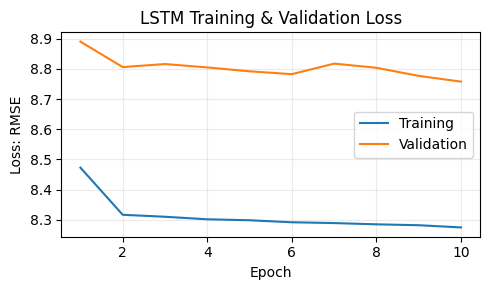

In [11]:
train_loss=results['LSTM']["train_rmse"]
val_loss=results['LSTM']["val_rmse"]
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(5, 3))
plt.plot(epochs, train_loss, label="Training")
plt.plot(epochs, val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss: RMSE")
plt.title("LSTM Training & Validation Loss")
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

# EVALUATE MODEL PREDICTIONS

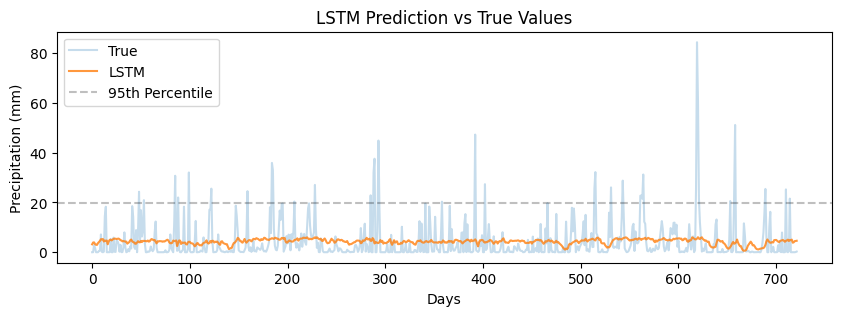

In [29]:
npz = np.load(data_path)
y_true = npz["y_test"]
threshold = np.percentile(y_true, 95)

y_pred_lstm = results["LSTM"]["y_pred"]
y_true_aligned = y_true[T - 1 + horizon : T - 1 + horizon + len(y_pred_lstm)]

plt.figure(figsize=(10,3))
plt.plot(y_true_aligned, alpha=0.25, label="True")
plt.plot(y_pred_lstm, alpha=0.8, label="LSTM")
plt.axhline(y=threshold, color='black', linestyle='--', label='95th Percentile', alpha=0.25)
plt.title("LSTM Prediction vs True Values")
plt.xlabel("Days")
plt.ylabel("Precipitation (mm)")
plt.legend()
plt.show()

# EVALUATE EXTREME EVENTS (>95TH PERCENTILE)

In [13]:
for model_name, result in results.items():
    y_pred = result['y_pred']
    name = model_name.replace("_", " ").upper()
    print(f"\nEvaluating extreme events for {name} model:")
    evaluate_extreme_events(y_true, y_pred, percentile=95)
    print("-"*50)


Evaluating extreme events for LSTM model:
Extreme events > 95th percentile -> RMSE: 28.97099494934082, MAE: 25.822168350219727
Total extreme events: 37, Total extreme events predicted: 0
--------------------------------------------------
